# **Tugas Besar Analisis Big Data**

## **Perbandingan Algoritma Naïve Bayes dan Regresi Logistik pada Klasifikasi Produk Olahraga Tokopedia Berdasarkan Gender**

KELOMPOK 1

1. TAUFIQURRAHMAN SYAH EFFENDI_120450051
2. ERICSON CHANDRA SIHOMBING_121450026
3. VENI ZAHARA KARTIKA_121450075
4. EVAN ARYAPUTRA_121450102
5. JASMINE GEORGINA SEKARTAJI_	121450159

## Instalasi PySpark

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=f429db799a32f8362c9a74ef98e84f7a5d65e8f318f94d597ecd0e2dd36a4310
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


## Import Library dan Dataset

In [ ]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [ ]:
df = spark.read.csv("/content/produk_olahraga_tokopedia.csv", header=True, inferSchema=True)
df.show(5)

+--------------------+----------+------------------+--------+
|                nama|     jenis|          kategori|  produk|
+--------------------+----------+------------------+--------+
|ROCKBROS XT-9002 ...|arm-sleeve|aksesoris-olahraga|olahraga|
|Rockbros XT056 Ma...|arm-sleeve|aksesoris-olahraga|olahraga|
|Tiento Hand Sleev...|arm-sleeve|aksesoris-olahraga|olahraga|
|Manset Tangan / A...|arm-sleeve|aksesoris-olahraga|olahraga|
|MANSET LENGAN NYL...|arm-sleeve|aksesoris-olahraga|olahraga|
+--------------------+----------+------------------+--------+
only showing top 5 rows



In [ ]:
df.printSchema()

root
 |-- nama: string (nullable = true)
 |-- jenis: string (nullable = true)
 |-- kategori: string (nullable = true)
 |-- produk: string (nullable = true)



## Preprocessing Data

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag
import string
import re

# remove non ASCII characters
def strip_non_ascii(data_str):
    ''' Returns the string without non ASCII characters'''
    stripped = (c for c in data_str if 0 < ord(c) < 127)
    return ''.join(stripped)
# setup pyspark udf function
strip_non_ascii_udf = udf(strip_non_ascii, StringType())

In [ ]:
df = df.withColumn('text_non_asci',strip_non_ascii_udf(df['nama']))
df.show(5,True)

+--------------------+----------+------------------+--------+--------------------+
|                nama|     jenis|          kategori|  produk|       text_non_asci|
+--------------------+----------+------------------+--------+--------------------+
|ROCKBROS XT-9002 ...|arm-sleeve|aksesoris-olahraga|olahraga|ROCKBROS XT-9002 ...|
|Rockbros XT056 Ma...|arm-sleeve|aksesoris-olahraga|olahraga|Rockbros XT056 Ma...|
|Tiento Hand Sleev...|arm-sleeve|aksesoris-olahraga|olahraga|Tiento Hand Sleev...|
|Manset Tangan / A...|arm-sleeve|aksesoris-olahraga|olahraga|Manset Tangan / A...|
|MANSET LENGAN NYL...|arm-sleeve|aksesoris-olahraga|olahraga|MANSET LENGAN NYL...|
+--------------------+----------+------------------+--------+--------------------+
only showing top 5 rows



In [ ]:
def remove_features(data_str):
    # compile regex
    url_re = re.compile('https?://(www.)?\w+\.\w+(/\w+)*/?')
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    num_re = re.compile('(\\d+)')
    mention_re = re.compile('@(\w+)')
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
    # convert to lowercase
    data_str = data_str.lower()
    # remove hyperlinks
    data_str = url_re.sub(' ', data_str)
    # remove @mentions
    data_str = mention_re.sub(' ', data_str)
    # remove puncuation
    data_str = punc_re.sub(' ', data_str)
    # remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
    # remove non a-z 0-9 characters and words shorter than 1 characters
    list_pos = 0
    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = word
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = cleaned_str + ' ' + word
            else:
                cleaned_str += ' '
        list_pos += 1

    return " ".join(cleaned_str.split())
# setup pyspark udf function
remove_features_udf = udf(remove_features, StringType())

In [ ]:
df = df.withColumn('removed',remove_features_udf(df['text_non_asci']))
df.show(5,True)

+--------------------+----------+------------------+--------+--------------------+--------------------+
|                nama|     jenis|          kategori|  produk|       text_non_asci|             removed|
+--------------------+----------+------------------+--------+--------------------+--------------------+
|ROCKBROS XT-9002 ...|arm-sleeve|aksesoris-olahraga|olahraga|ROCKBROS XT-9002 ...|rockbros xt arm s...|
|Rockbros XT056 Ma...|arm-sleeve|aksesoris-olahraga|olahraga|Rockbros XT056 Ma...|rockbros xt manse...|
|Tiento Hand Sleev...|arm-sleeve|aksesoris-olahraga|olahraga|Tiento Hand Sleev...|tiento hand sleev...|
|Manset Tangan / A...|arm-sleeve|aksesoris-olahraga|olahraga|Manset Tangan / A...|manset tangan arm...|
|MANSET LENGAN NYL...|arm-sleeve|aksesoris-olahraga|olahraga|MANSET LENGAN NYL...|manset lengan nyl...|
+--------------------+----------+------------------+--------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
import re
import string

def clean_text(text):
    # Menghapus angka
    text = re.sub(r'\d+', '', text)

    # Menghapus tanda petik
    text = text.replace("'", "")

    # Menghapus tanda baca dan simbol-simbol khusus
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Menghapus spasi berlebihan
    text = re.sub(r'\s+', ' ', text)

    # Mengubah ke huruf kecil
    text = text.lower()

    return text.strip()

clean_text_udf = udf(clean_text, StringType())

In [ ]:
df = df.withColumn('clean_text',remove_features_udf(df['removed']))
df.show(5,True)

+--------------------+----------+------------------+--------+--------------------+--------------------+--------------------+
|                nama|     jenis|          kategori|  produk|       text_non_asci|             removed|          clean_text|
+--------------------+----------+------------------+--------+--------------------+--------------------+--------------------+
|ROCKBROS XT-9002 ...|arm-sleeve|aksesoris-olahraga|olahraga|ROCKBROS XT-9002 ...|rockbros xt arm s...|rockbros xt arm s...|
|Rockbros XT056 Ma...|arm-sleeve|aksesoris-olahraga|olahraga|Rockbros XT056 Ma...|rockbros xt manse...|rockbros xt manse...|
|Tiento Hand Sleev...|arm-sleeve|aksesoris-olahraga|olahraga|Tiento Hand Sleev...|tiento hand sleev...|tiento hand sleev...|
|Manset Tangan / A...|arm-sleeve|aksesoris-olahraga|olahraga|Manset Tangan / A...|manset tangan arm...|manset tangan arm...|
|MANSET LENGAN NYL...|arm-sleeve|aksesoris-olahraga|olahraga|MANSET LENGAN NYL...|manset lengan nyl...|manset lengan nyl...|


## Data Labeling

In [ ]:
from pyspark.sql.functions import when, lower, col

def label_product(nama):
    nama_lower = nama.lower()
    if any(kata in nama_lower for kata in ['wanita', 'perempuan', 'girl', 'ladies', 'cewek']):
        if any(kata in nama_lower for kata in ['laki-laki', 'pria', 'boys', 'gentlemen', 'cowok']):
            return 0  # Mengandung keduanya, label 0
        else:
            return 1 #cewek
    elif any(kata in nama_lower for kata in ['laki-laki', 'pria', 'boys', 'gentlemen', 'cowok']):
        return 2 #cowok
    else:
        return 0 #unisex

label_product_udf = udf(label_product, IntegerType())
df = df.withColumn('label', label_product_udf(df['clean_text']))
df.show(25,True)

+--------------------+----------+------------------+--------+--------------------+--------------------+--------------------+-----+
|                nama|     jenis|          kategori|  produk|       text_non_asci|             removed|          clean_text|label|
+--------------------+----------+------------------+--------+--------------------+--------------------+--------------------+-----+
|ROCKBROS XT-9002 ...|arm-sleeve|aksesoris-olahraga|olahraga|ROCKBROS XT-9002 ...|rockbros xt arm s...|rockbros xt arm s...|    0|
|Rockbros XT056 Ma...|arm-sleeve|aksesoris-olahraga|olahraga|Rockbros XT056 Ma...|rockbros xt manse...|rockbros xt manse...|    0|
|Tiento Hand Sleev...|arm-sleeve|aksesoris-olahraga|olahraga|Tiento Hand Sleev...|tiento hand sleev...|tiento hand sleev...|    0|
|Manset Tangan / A...|arm-sleeve|aksesoris-olahraga|olahraga|Manset Tangan / A...|manset tangan arm...|manset tangan arm...|    0|
|MANSET LENGAN NYL...|arm-sleeve|aksesoris-olahraga|olahraga|MANSET LENGAN NYL...|m

In [ ]:
# Menghitung jumlah data untuk setiap label
label_counts = df.groupBy('label').count().collect()

# Konversikan hasil perhitungan ke Pandas DataFrame
label_counts_pd = pd.DataFrame(label_counts, columns=['label', 'count'])
label_counts_pd

,label,count
0,1,40640
1,2,34567
2,0,1036081


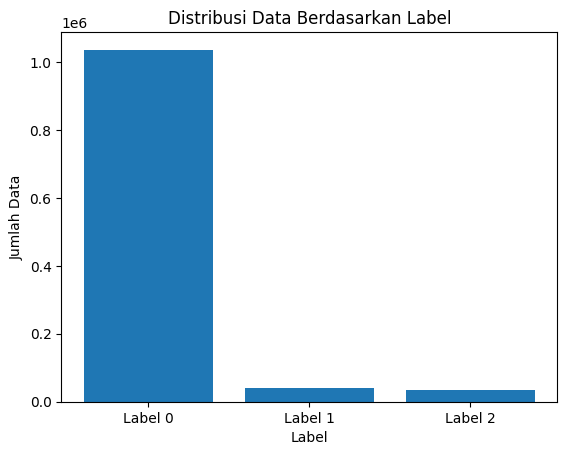

In [ ]:
# Buat histogram menggunakan Matplotlib
plt.bar(label_counts_pd['label'], label_counts_pd['count'], tick_label=['Label 1', 'Label 2', 'Label 0'])
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.title('Distribusi Data Berdasarkan Label')
plt.show()

## Klasifikasi Naive Bayes

In [ ]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = df.randomSplit([0.6, 0.4])

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, Tokenizer, HashingTF, IDF
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline

# StringIndexer untuk mengubah label menjadi indeks numerik
label_indexer = StringIndexer(inputCol='label', outputCol='label_indexed')

# Tokenizer untuk memecah teks menjadi kata-kata
tokenizer = Tokenizer(inputCol='clean_text', outputCol='words')

# HashingTF untuk menghitung frekuensi term
hashing_tf = HashingTF(inputCol='words', outputCol='raw_features')

# IDF untuk menghitung frekuensi term yang ditimbang (Term Frequency-Inverse Document Frequency)
idf = IDF(inputCol='raw_features', outputCol='features')

# Naive Bayes model
nb = NaiveBayes(featuresCol='features', labelCol='label_indexed')

# Pipeline untuk menggabungkan semua tahapan
pipeline = Pipeline(stages=[label_indexer, tokenizer, hashing_tf, idf, nb])

# Melatih model
model = pipeline.fit(trainingData)

# Melakukan prediksi
predictions = model.transform(testData)
predictions.select('clean_text', 'label', 'prediction', 'probability').show(10, truncate=False)

+------------------------------------------------------------------+-----+----------+--------------------------------------------------------------+
|clean_text                                                        |label|prediction|probability                                                   |
+------------------------------------------------------------------+-----+----------+--------------------------------------------------------------+
|alat sonar deteksi ikan portable portable fish finder             |0    |0.0       |[1.0,4.942297252412854E-80,3.589152763819591E-79]             |
|laser rangefinder the truth model bushnell                        |0    |0.0       |[1.0,5.212050229253306E-43,1.6772444129686327E-43]            |
|tas consina millau bridge                                         |0    |0.0       |[0.9999999217719046,7.822809344964312E-8,1.90343279980542E-15]|
|teropong monokular focus and zoom lens                            |0    |0.0       |[1.0,1.88383400808311

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluator untuk menghitung metrik evaluasi
evaluator = MulticlassClassificationEvaluator(labelCol='label_indexed', predictionCol='prediction')

# Akurasi
accuracy = evaluator.setMetricName('accuracy').evaluate(predictions)
print(f'Akurasi: {accuracy:.4f}')

Akurasi: 0.8684


In [ ]:
# Weighted precision
weighted_precision = evaluator.setMetricName('weightedPrecision').evaluate(predictions)
print(f'Weighted Precision: {weighted_precision:.4f}')

Weighted Precision: 0.9509


In [ ]:
# Weighted recall
weighted_recall = evaluator.setMetricName('weightedRecall').evaluate(predictions)
print(f'Weighted Recall: {weighted_recall:.4f}')

Weighted Recall: 0.8684


In [ ]:
# Weighted F1-score
weighted_f1 = evaluator.setMetricName('weightedFMeasure').evaluate(predictions)
print(f'Weighted F1-score: {weighted_f1:.4f}')

Weighted F1-score: 0.8962


In [ ]:
# Confusion matrix
predictions.crosstab('label', 'prediction').show()

+----------------+------+-----+-----+
|label_prediction|   0.0|  1.0|  2.0|
+----------------+------+-----+-----+
|               0|358307|20686|35663|
|               1|   830|15319|  175|
|               2|  1084|  101|12673|
+----------------+------+-----+-----+



## Klasifikasi Regresi Logistik

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, Tokenizer, HashingTF, IDF
from pyspark.ml import Pipeline

# StringIndexer untuk mengubah label menjadi indeks numerik
label_indexer = StringIndexer(inputCol='label', outputCol='label_indexed')

# Tokenizer untuk memecah teks menjadi kata-kata
tokenizer = Tokenizer(inputCol='clean_text', outputCol='words')

# HashingTF untuk menghitung frekuensi term
hashing_tf = HashingTF(inputCol='words', outputCol='raw_features')

# IDF untuk menghitung frekuensi term yang ditimbang (Term Frequency-Inverse Document Frequency)
idf = IDF(inputCol='raw_features', outputCol='features')

# Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='label_indexed', maxIter=100)

# Pipeline untuk menggabungkan semua tahapan
pipeline = Pipeline(stages=[label_indexer, tokenizer, hashing_tf, idf, lr])

# Melatih model
model = pipeline.fit(trainingData)

# Melakukan prediksi
predictions = model.transform(testData)
predictions.select('clean_text', 'label', 'prediction', 'probability').show(10, truncate=False)

+------------------------------------------------------------------+-----+----------+-----------------------------------------------------------------+
|clean_text                                                        |label|prediction|probability                                                      |
+------------------------------------------------------------------+-----+----------+-----------------------------------------------------------------+
|alat sonar deteksi ikan portable portable fish finder             |0    |0.0       |[1.0,1.8989781891757505E-17,7.638014573615904E-18]               |
|laser rangefinder the truth model bushnell                        |0    |0.0       |[0.999999999999994,5.051987076081146E-15,9.485393454445235E-16]  |
|tas consina millau bridge                                         |0    |0.0       |[1.0,2.0177702036428326E-21,2.162366080302283E-27]               |
|teropong monokular focus and zoom lens                            |0    |0.0       |[1.

In [ ]:
# Evaluasi model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label_indexed', predictionCol='prediction')
accuracy = evaluator.setMetricName('accuracy').evaluate(predictions)
print(f'Akurasi: {accuracy:.4f}')

Akurasi: 0.9967


In [ ]:
# Weighted precision
weighted_precision = evaluator.setMetricName('weightedPrecision').evaluate(predictions)
print(f'Weighted Precision: {weighted_precision:.4f}')

Weighted Precision: 0.9967


In [ ]:
# Weighted recall
weighted_recall = evaluator.setMetricName('weightedRecall').evaluate(predictions)
print(f'Weighted Recall: {weighted_recall:.4f}')

Weighted Recall: 0.9967


In [ ]:
# Weighted f1-score
weighted_f1 = evaluator.setMetricName('weightedFMeasure').evaluate(predictions)
print(f'Weighted F1-score: {weighted_f1:.4f}')

Weighted F1-score: 0.9967


In [ ]:
# Confussion Matrix
predictions.crosstab('label', 'prediction').show()

+----------------+------+-----+-----+
|label_prediction|   0.0|  1.0|  2.0|
+----------------+------+-----+-----+
|               0|413720|  551|  385|
|               1|   317|16006|    1|
|               2|   236|    0|13622|
+----------------+------+-----+-----+

